In [126]:
#General Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

#Tess CPM Imports
import lightkurve as lk
from astropy.io import fits
from astropy.wcs import WCS
import tess_cpm

#TP CPM Imports
import requests
import shutil

#ZTF Imports
import urllib.request, json 
from antares_client.search import search as antares_search
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

# Notebook to test reduction of a ZTF Transient

Sample Target: SN 2019neq/ZTF19abpbopt  
https://lasair.roe.ac.uk/object/ZTF19abpbopt/  
https://supernova.exchange/view_object?name=2019neq  
pos=(268.611400 +47.261267)  

>## This is in a Chip-Gap!  Too bad.  New Target, boring but bright Ia:

>Sample Target: SN 2019ptv/ZTF19abxfunp 
>https://lasair.roe.ac.uk/object/ZTF19abxfunp/
>pos=(300.289593, 50.860091)

>Swap to 19ust when data becomes available


## First, get the ZTF data from a broker 
Antares to start - it has a decent API and is where the PrestoColor Filter will live  
Start with assuming the user has a know ZTF ID; can branch out to different search options easily enough  
'properties.ztf_programpi': 'TESS' will enforce data from the TESS follow-up program only (i.e.simultaneous coverage)

In [133]:
#ztf_name="ZTF19abpbopt"
ztf_name="ZTF19abxfunp"

In [134]:
antares_query = {
  "query": {
    "wildcard": {
      "properties.ztf_object_id.keyword": ztf_name
    }
  }
}

antares_data= antares_search(antares_query)
antares_data

[{'alert_id': 178995511,
  'survey': 1,
  'original_id': 979260235715015033,
  'ra': 300.2895539,
  'dec': 50.8600715,
  'htm20': 14068482590175,
  'mjd': 58733.260231500026,
  'locus_id': 5205600,
  'ingest_time': 1567847773,
  'properties': {'ztf_fid': '2',
   'ztf_pid': '979260235715',
   'ztf_programid': '1',
   'ztf_candid': '979260235715015033',
   'ztf_tblid': '33',
   'ztf_nid': '979',
   'ztf_rcid': '57',
   'ztf_field': '767',
   'ztf_nneg': '3',
   'ztf_nbad': '0',
   'ztf_ndethist': '6',
   'ztf_ncovhist': '743',
   'ztf_tooflag': '0',
   'ztf_objectidps1': '169033002897112646',
   'ztf_objectidps2': '169033002870035708',
   'ztf_objectidps3': '169033002844443803',
   'ztf_nmtchps': '28',
   'ztf_rfid': '767120257',
   'ztf_nframesref': '15',
   'ztf_nmatches': '2053',
   'provenance_id': '8264',
   'ztf_jd': '2458733.7602315',
   'ztf_diffmaglim': '20.455928802490234',
   'ztf_xpos': '1702.000244140625',
   'ztf_ypos': '2097.531494140625',
   'ztf_ra': '300.2895539',
   'z

# Lets turn this into a ZTF Lightcurve  
Build a minimal dataframe from just what we care about for now

In [135]:
ztf_lc=pd.DataFrame({"mjd":[],
                       "mag":[],
                       "mag_err":[],
                       "mag_lim":[],
                       "band":[]
})

for item in antares_data:
    if 'ztf_magpsf' in item['properties']:
        mag=float(item['properties']['ztf_magpsf'])
    else:
        mag=float('NaN')
    ztf_lc=ztf_lc.append(pd.DataFrame({"mjd":float(item['mjd']),
                                           "mag":mag,
                                           "mag_err":float(item['properties']['ztf_magzpscirms']),
                                           "mag_lim":float(item['properties']['ztf_diffmaglim']),
                                           "band":   item['properties']['passband']
                                          },index=[0]),
                             ignore_index = True)

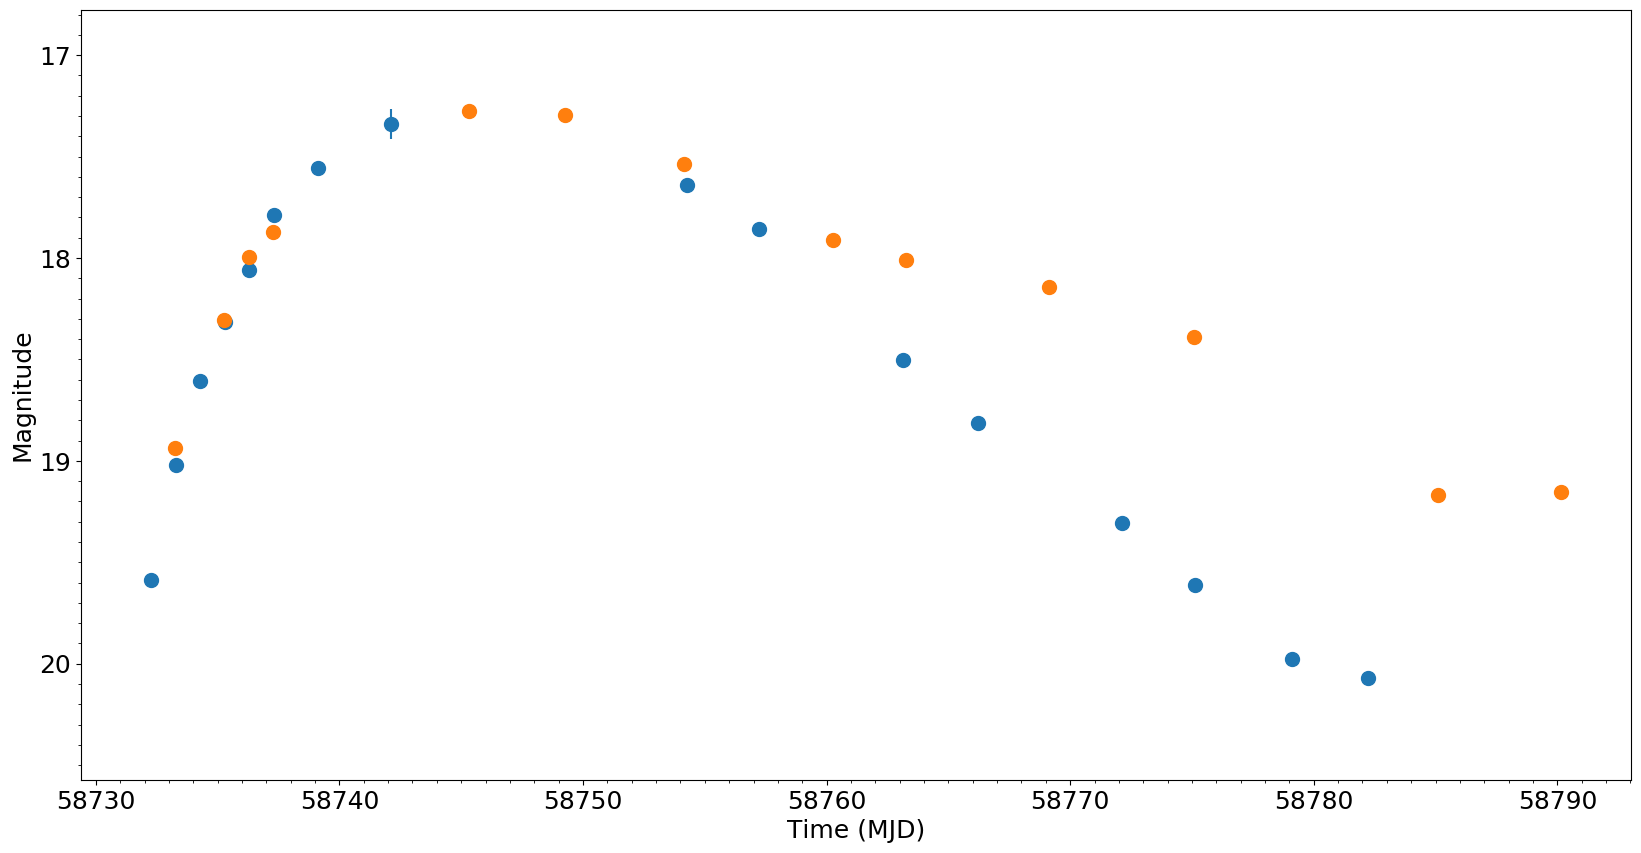

In [136]:
plt.style.use('default')
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(20, 10))
ax.errorbar(ztf_lc.loc[(ztf_lc.band == 'g'), 'mjd'],
            ztf_lc.loc[(ztf_lc.band == 'g'), 'mag'],
            ztf_lc.loc[(ztf_lc.band == 'g'), 'mag_err'],
            fmt='o',markersize=10)
ax.errorbar(ztf_lc.loc[(ztf_lc.band == 'R'), 'mjd'],
            ztf_lc.loc[(ztf_lc.band == 'R'), 'mag'],
            ztf_lc.loc[(ztf_lc.band == 'R'), 'mag_err'],
            fmt='o',markersize=10)

ax.set_ylim(np.nanmax(ztf_lc.mag+.5),np.nanmin(ztf_lc.mag-.5))
ax.set_xlabel('Time (MJD)')
ax.set_ylabel('Magnitude')

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

## Now, Lets do some basic GP interpolation  
We're going to need to re-sample this onto a common grid with the TESS Observations  
Quick & Dirty, this could be done better in detail - should use 2-gp not 2 ind., etc. 

In [186]:
def ztf_gpinterp(mjd,mag):
    time=np.array(mjd).reshape(-1,1)
    val=np.array(mag)
    
    #kernel =1.0*RBF(length_scale=100, length_scale_bounds=(1e-3,1e3)) #\
    #+ WhiteKernel(noise_level=1, noise_level_bounds=(1e-2,1e3))
    
    #kernel = Matern(length_scale=10.0, length_scale_bounds=(1, 100), nu=2.5) \
    kernel =1.0*RBF(length_scale=5, length_scale_bounds=(1,1e2)) \
    + WhiteKernel(noise_level=1)
    
    gp=GaussianProcessRegressor(kernel=kernel, alpha=0.0)
    gp.fit(time, val)
    time_pred=np.linspace(min(time),max(time)).reshape(-1,1)
    val_pred,val_sigma = gp.predict(time_pred, return_std=True)
    return time_pred.reshape(-1), val_pred, val_sigma

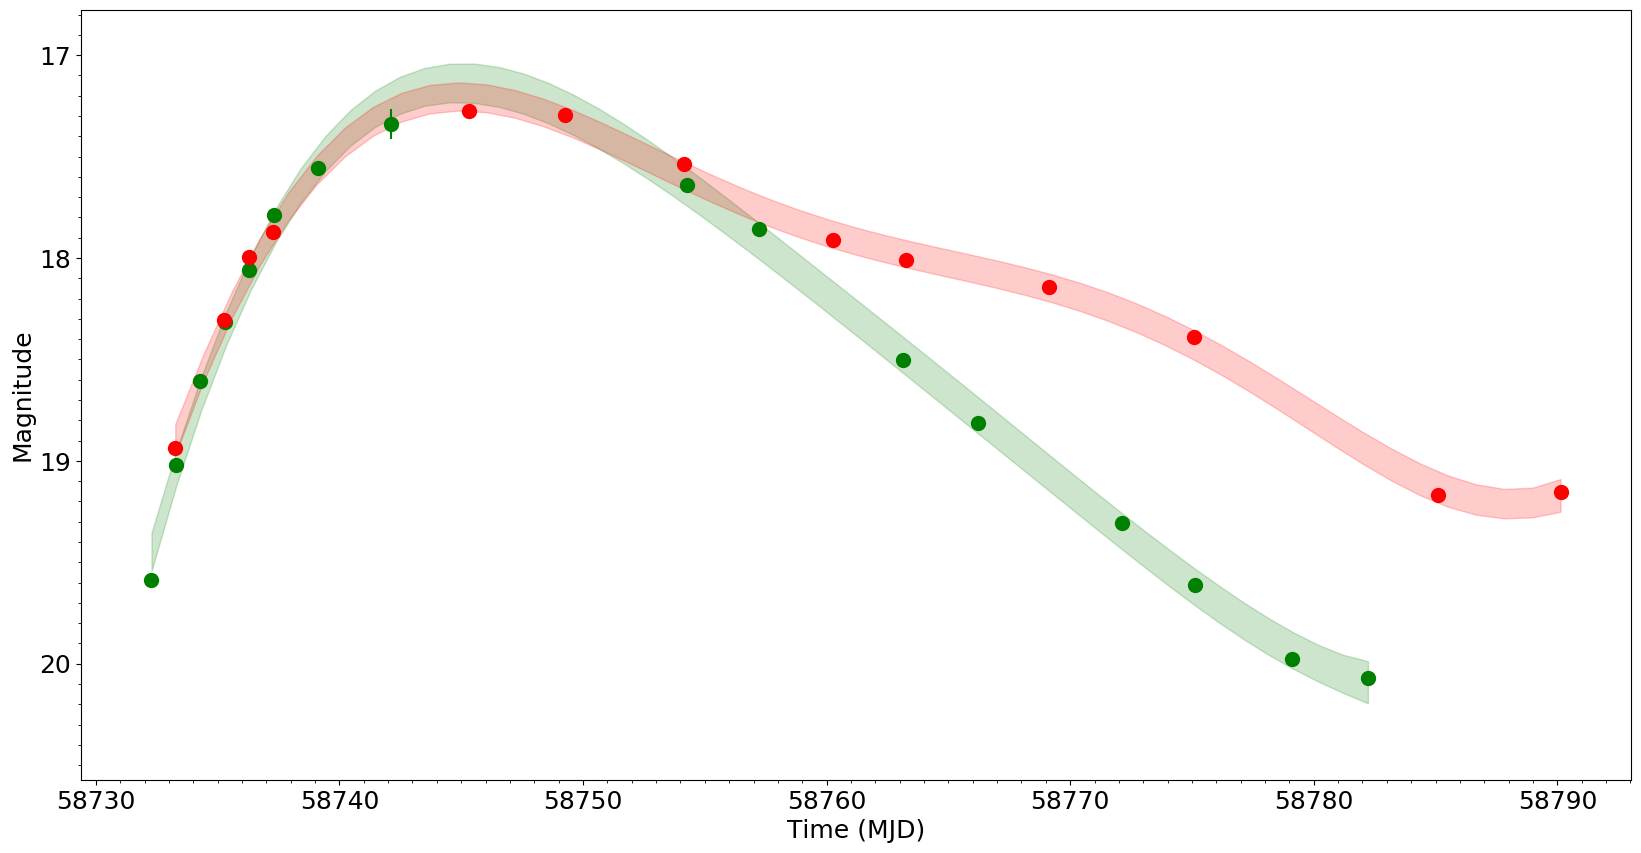

In [187]:
plt.plfig, ax = plt.subplots(figsize=(20, 10))

ax.errorbar(ztf_lc.loc[(ztf_lc.band == 'g'), 'mjd'],
            ztf_lc.loc[(ztf_lc.band == 'g'), 'mag'],
            ztf_lc.loc[(ztf_lc.band == 'g'), 'mag_err'],
            fmt='o',color='g',markersize=10)
ax.errorbar(ztf_lc.loc[(ztf_lc.band == 'R'), 'mjd'],
            ztf_lc.loc[(ztf_lc.band == 'R'), 'mag'],
            ztf_lc.loc[(ztf_lc.band == 'R'), 'mag_err'],
            fmt='o',color='r',markersize=10)

gp_mjd_g, \
gp_mag_g, \
gp_sigma_g = ztf_gpinterp(ztf_lc.loc[(ztf_lc.band == 'g') & (np.invert(np.isnan(ztf_lc.mag))),'mjd'],
                          ztf_lc.loc[(ztf_lc.band == 'g') & (np.invert(np.isnan(ztf_lc.mag))),'mag'])

gp_mjd_r, \
gp_mag_r, \
gp_sigma_r = ztf_gpinterp(ztf_lc.loc[(ztf_lc.band == 'R') & (np.invert(np.isnan(ztf_lc.mag))),'mjd'],
                          ztf_lc.loc[(ztf_lc.band == 'R') & (np.invert(np.isnan(ztf_lc.mag))),'mag'])


ax.fill_between(gp_mjd_g,gp_mag_g-gp_sigma_g,gp_mag_g+gp_sigma_g,color='g',alpha=0.20)

ax.fill_between(gp_mjd_r,gp_mag_r-gp_sigma_r,gp_mag_r+gp_sigma_r,color='r',alpha=0.20)

ax.set_ylim(np.nanmax(ztf_lc.mag+.5),np.nanmin(ztf_lc.mag-.5))
ax.set_xlabel('Time (MJD)')
ax.set_ylabel('Magnitude')

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

# Start TESS Reduction
Following along from supernovae.ipynb

## Let's use the ZTF data from Antares to download a TESS cutout from a FFI
From the file in the supernovae notebook it looks like cpm is currently using 100 x 100  
pos is quick and dirty - just taking the first detection; should be turned into median probably and skycoord obj  
this download could be done better; but proof of concept

In [188]:
ztf_pos=(antares_data[0]['ra'],antares_data[0]['dec'])
size=100
ztf_tpf="tesscut.fits"
tesscut_query=\
"https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0}&dec={1}&x={2}&y={2}".format(ztf_pos[0],ztf_pos[1],size)
tesscut_request=requests.get(tesscut_query, allow_redirects=True)
with open(ztf_tpf,'wb') as fout:
    shutil.copyfileobj(tesscut_request.raw, fout)

## Allright, so use new tpf to run through CPM  
Perhaps this should be optionally kept in memory instead, but the download is a bit annoying . 


In [189]:
sn = tess_cpm.CPM(ztf_tpf)#, remove_bad=True)

In [190]:
#sn.set_poly_model(1, 4, 2)
sn.set_target(50, 50)
sn.set_exclusion(10)
sn.set_predictor_pixels(256*4, method='cosine_similarity')

AttributeError: 'CPM' object has no attribute 'target_data'

In [ ]:
sn.lsq(0.1, rescale=True, polynomials=True)

In [ ]:
sn.get_aperture_lc(show_pixel_lc=True, show_aperture_lc=True)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(sn.time, sn.rescaled_target_fluxes, '.')
n = 10
# locs, mask = c.get_contributing_pixels(n)
# print(c.rescaled_predictor_pixels_fluxes.shape)
# print(locs[2])
# plt.plot(c.time, c.rescaled_im_fluxes[:, locs[0][0], locs[0][1]], '-')
# plt.plot(c.time, c.rescaled_predictor_pixels_fluxes[:, 4])
for i in range(n):
    plt.figure(figsize=(12, 8))
    t = sn.rescaled_target_fluxes
    p = sn.rescaled_predictor_pixels_fluxes[:, i]
    plt.plot(sn.time, t, '.')
    plt.plot(sn.time, p, '-', alpha=0.4)
    plt.title(np.dot(p, t)/(np.linalg.norm(p)*np.linalg.norm(t)), fontsize=25)
    plt.show();